In [ ]:
import importlib
import project_utils.deciles as deciles
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from general_utils import utils
from general_utils.OverallDetailComparisonPlot import OverallDetailComparisonPlot
import os
from matplotlib import colors as mcolors
import math
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import general_utils.LDI_VIF as LV
import numpy as np
import project_utils.binary_classification as bc
importlib.reload(bc)

utils.default_plot_format()
utils.pd_display_settings(3)

In [1]:
data_path = r"processed_data\raw_metrics\processed_10min_Nabian.pkl"
#data_path = r"processed_data\raw_metrics\comorbidities.pkl"

In [2]:
pickled = pd.read_pickle(data_path)
data = pickled["data"]
indicator_columns = pickled["indicator_columns"]
time_metrics = pickled["time_metrics"]
frequency_metrics = pickled["frequency_metrics"]
non_linear_metrics = pickled["non_linear_metrics"]
data.tail()

NameError: name 'pd' is not defined

In [ ]:
median_melted = deciles.produce_median_melt(data, indicator_columns)
median_pivot = median_melted.pivot(index=["id", "DPN"], columns="metric", values="value").reset_index()

Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False  True False
  True  True]
              precision    recall  f1-score   support

       False       0.96      1.00      0.98        22
        True       1.00      0.75      0.86         4

    accuracy                           0.96        26
   macro avg       0.98      0.88      0.92        26
weighted avg       0.96      0.96      0.96        26

Accuracy: 0.9615384615384616


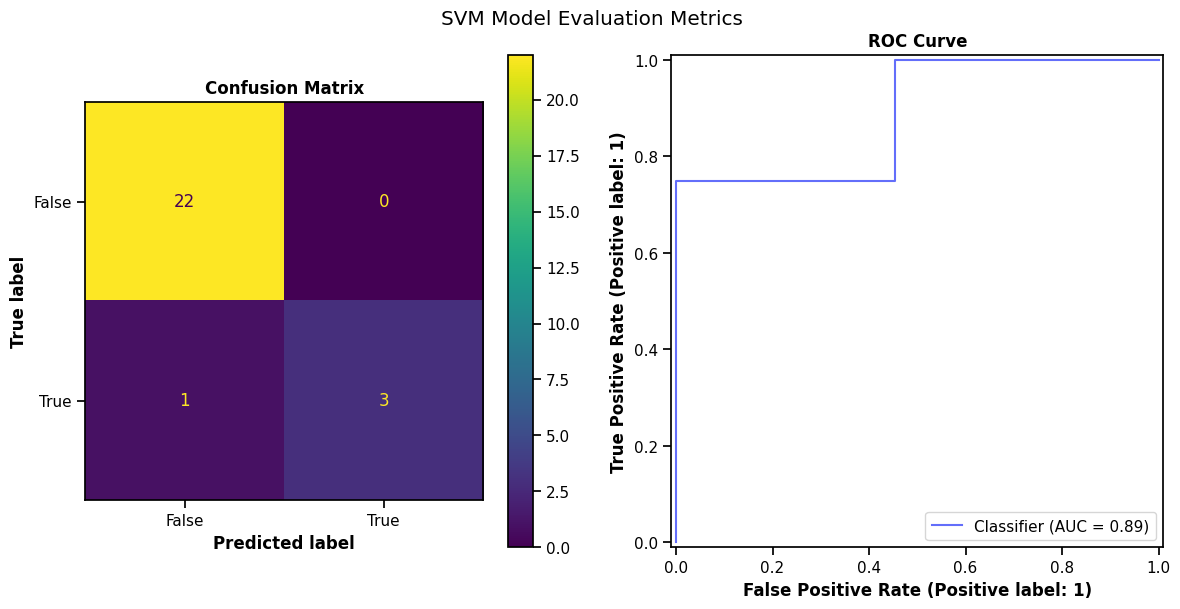

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
importlib.reload(bc)

def build_svm(data, columns = None, kernel='linear'):
    y = median_pivot["DPN"]
    X = data.drop(columns=["id", "DPN"])  # Features
    if columns:
        X = X[columns]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Build and train the SVM model
    svm_model = SVC(kernel=kernel, random_state=42)
    svm_model.fit(X_scaled, y)
    return svm_model, X_scaled, y


def plot_cvm_result(svm_model, X_scaled, y):
    
    y_pred = svm_model.predict(X_scaled)
    print("Predictions:", y_pred)
    print(classification_report(y, y_pred))
    print("Accuracy:", accuracy_score(y, y_pred))
    res = {
            'confusion_matrix': bc.confusion_matrix(y, y_pred),
            'y_pred_proba': svm_model.decision_function(X_scaled)
        }

    # Call the function to plot evaluation metrics
    bc.plot_evaluation_metrics(res, y, title="SVM Model Evaluation Metrics")

plot_cvm_result(*build_svm(median_pivot))

In [ ]:
import importlib
import general_utils.LDI_VIF as LV
importlib.reload(LV)

vif_median = median_pivot.copy()


def automatic_vif_reduction(data, keep_n=5):
    data=data.copy()
    removed_features = []
    for _ in range(len(data.columns) - 2 - keep_n):
        vif_data = LV.get_vif(data.drop(columns=['id', 'DPN']))
        max_vif_value = vif_data["Full VIF"].max()

        max_vif_col = vif_data.loc[vif_data["Full VIF"] == max_vif_value, "feature"].iloc[0]
        data = data.drop(columns=[max_vif_col])
        removed_features.append(max_vif_col)
    print(f"Removed: {removed_features}")
    return data, removed_features


def plot_vif_reduction(vif_median, removed_features):
    remaining_features = [col for col in vif_median.columns if col not in removed_features + ['id', 'DPN']]
    print(f"Remaining features: {remaining_features}")
    lda_df, lda = LV.perform_lda(vif_median, remaining_features)
    LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
    LV.show_linear_lda_stats(lda, remaining_features)
    LV.plot_vif(LV.get_vif(vif_median.drop(columns=['id', 'DPN'])))

#vif_median, removed_features = automatic_vif_reduction(median_pivot.copy())
#plot_vif_reduction(vif_median, removed_features)


Removed: ['SD1', 'SDRR', 'ApEn', 'Mean HR (bpm)', 'VLF Peak Frequency', 'DFA α1', 'LF Peak Frequency', 'RMSSD', 'HF Peak Frequency', 'DFA α2', 'SD2', 'LF÷HF Ratio', 'SampEn', 'LF Power']

 columns left: Index(['id', 'DPN', 'D2', 'HF Power', 'S', 'SD1÷SD2', 'VLF Power',
       'pNN50 (%)'],
      dtype='object', name='metric')
Predictions: [False False False False False False False False False False False  True
 False False False False False False False False False False  True False
  True False]
              precision    recall  f1-score   support

       False       0.91      0.95      0.93        22
        True       0.67      0.50      0.57         4

    accuracy                           0.88        26
   macro avg       0.79      0.73      0.75        26
weighted avg       0.88      0.88      0.88        26

Accuracy: 0.8846153846153846


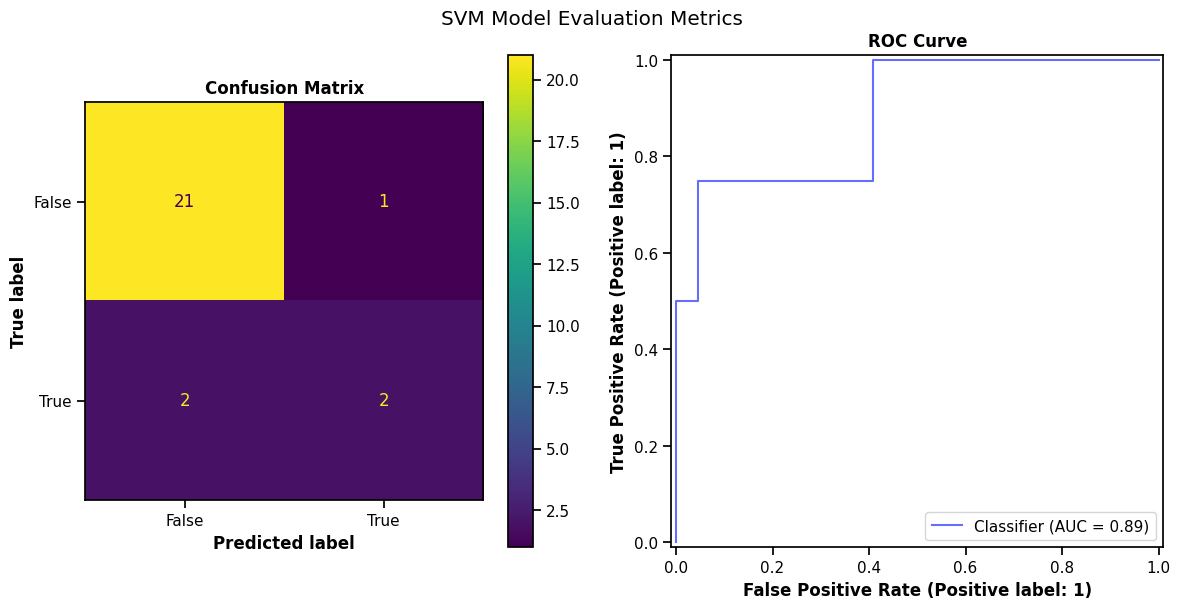

Remaining features: ['D2', 'HF Power', 'S', 'SD1÷SD2', 'VLF Power', 'pNN50 (%)']


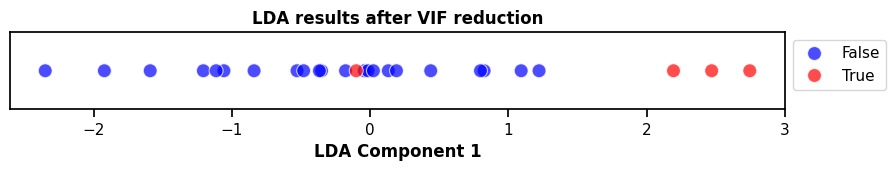

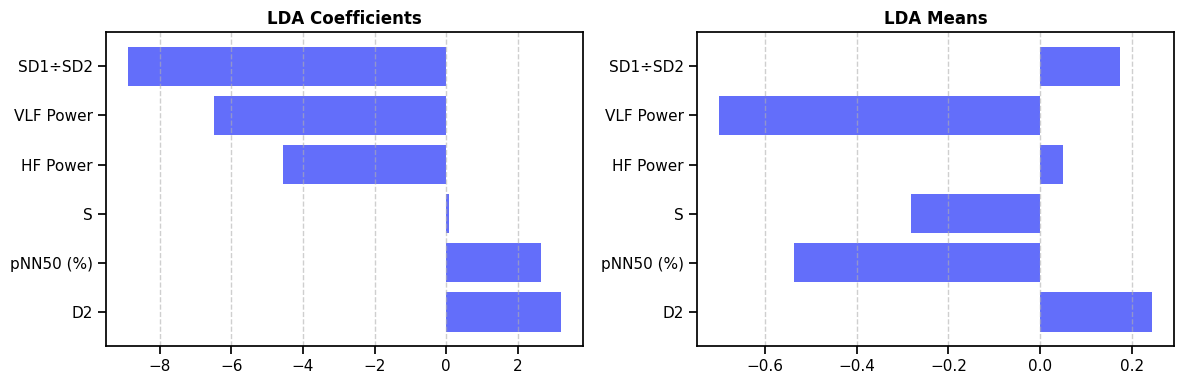

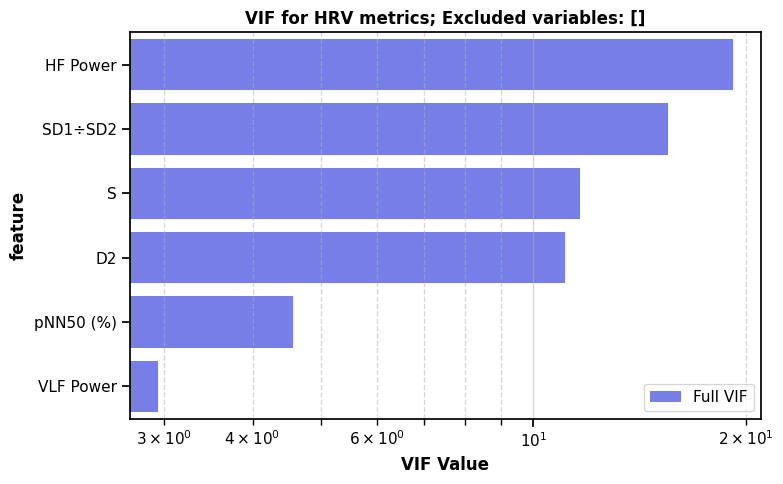

In [ ]:

vif_median, removed_features = automatic_vif_reduction(median_pivot, 6)
print("\n columns left:",vif_median.columns)
plot_cvm_result(*build_svm(vif_median))
plot_vif_reduction(vif_median, removed_features)

## Recursive SVM feature reduction

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

In [ ]:

#data = median_pivot.copy()
#y = data["DPN"]  # Target
#X = data.drop(columns=["id", "DPN"])  # Features

#estimator = SVR(kernel="linear")

#selector = RFECV(estimator, step=1, cv=5)
#selector = selector.fit(X, y)

Optimal number of features: 1
Selected features: Index(['ApEn'], dtype='object', name='metric')

# Linear SVM with feature selection

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
import warnings
from sklearn.feature_selection import SequentialFeatureSelector

Selected 10 features: ['ApEn', 'D2', 'DFA α1', 'DFA α2', 'HF Peak Frequency', 'HF Power', 'LF Peak Frequency', 'LF Power', 'LF÷HF Ratio', 'Mean HR (bpm)']
Predictions: [False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False]
              precision    recall  f1-score   support

       False       0.88      1.00      0.94        22
        True       1.00      0.25      0.40         4

    accuracy                           0.88        26
   macro avg       0.94      0.62      0.67        26
weighted avg       0.90      0.88      0.85        26

Accuracy: 0.8846153846153846


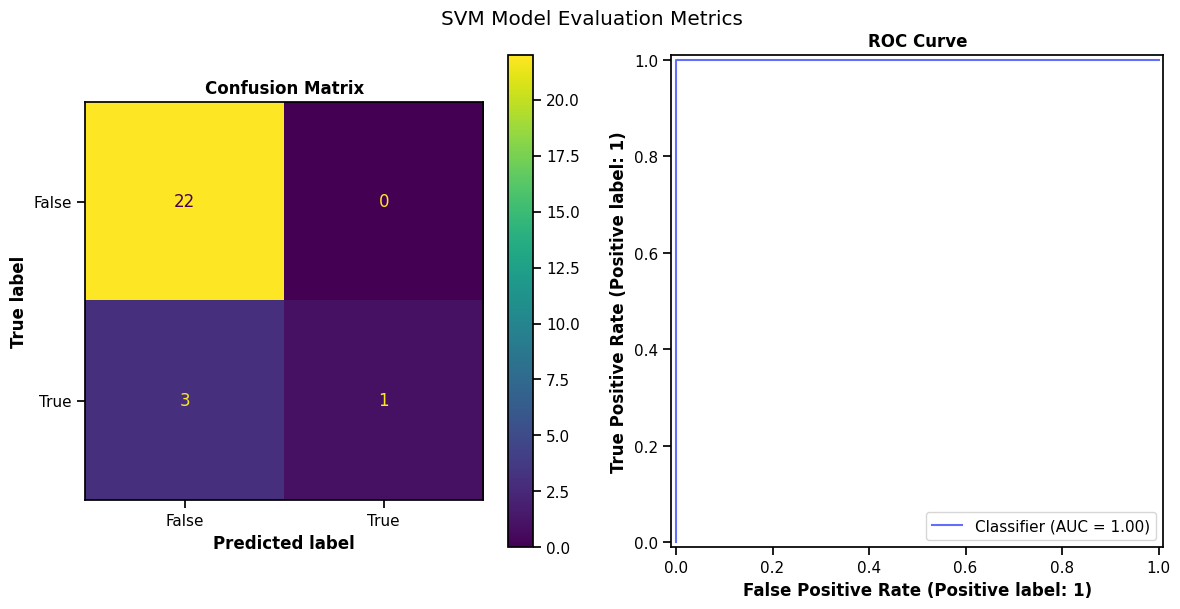

In [ ]:


warnings.filterwarnings('ignore')
data = median_pivot.copy()

y = data["DPN"]  # Target
X = data.drop(columns=["id", "DPN"])  # Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

estimator = SVC(kernel='rbf', random_state=42)
estimator.fit(X_scaled, y)

sfs = SequentialFeatureSelector(estimator, n_features_to_select='auto', direction="forward", scoring='precision', cv=5)
sfs.fit(X_scaled, y)
selected_features = X.columns[sfs.get_support()].tolist()

print(f"Selected {len(selected_features)} features:", selected_features)

plot_cvm_result(*build_svm(data, selected_features,'rbf'))

In [ ]:
plot_cvm_result(*build_svm(data, selected_features,'rbf'))

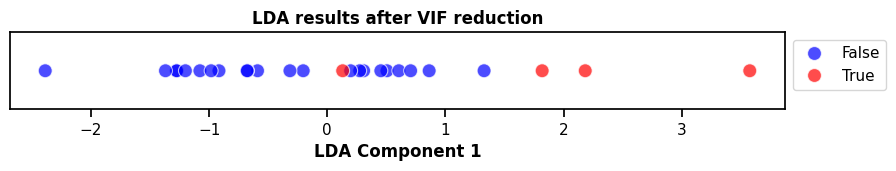

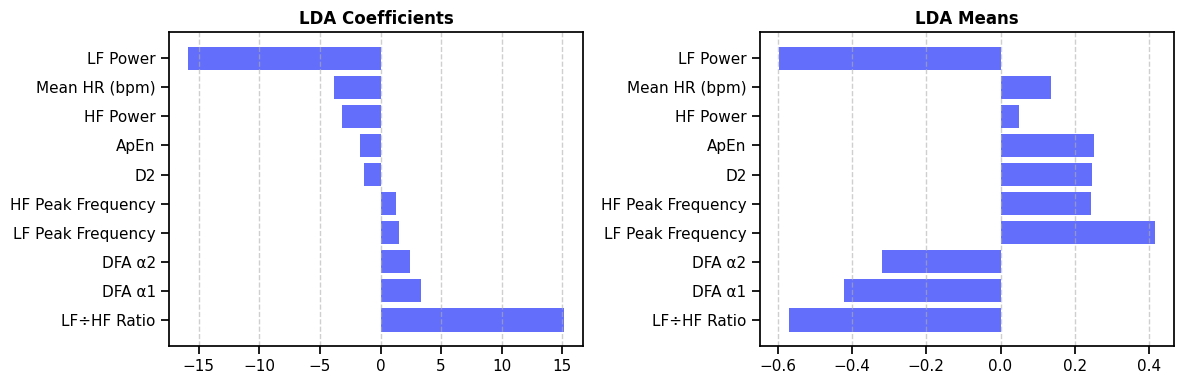

,Columns,LDA Coef,Means
0,ApEn,-1.69,0.25
1,D2,-1.35,0.25
2,DFA α1,3.36,-0.42
3,DFA α2,2.47,-0.32
4,HF Peak Frequency,1.26,0.24
5,HF Power,-3.21,0.0501
6,LF Peak Frequency,1.52,0.42
7,LF Power,-15.92,-0.60
8,LF÷HF Ratio,15.16,-0.57
9,Mean HR (bpm),-3.85,0.14


In [ ]:

lda_df, lda = LV.perform_lda(median_pivot, selected_features)
LV.plot_linear_lda(lda_df, "LDA results after VIF reduction")
LV.show_linear_lda_stats(lda, selected_features)

#